In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# centered full window sizes
front_window = '7h' # ±3h, rolling interval is [-3,+4) h
jet_window = '181min' # ±90min, rolling interval is [-1.5,+1.5) h

## load jets

In [3]:
# Sept 2019 -- Sept 2021
jet_ids = xr.open_dataset('LiDAR/full_E06_LLJs.nc')
jet_ids = jet_ids.assign_coords(t=jet_ids['datetime'])

# April - June 2020
#jet_ids = jet_ids.sel(t=(slice('2020-04-01', '2020-07-01')))

# April - June 2021
#jet_ids = jet_ids.sel(t=(slice('2021-04-01', '2021-07-01')))

# July 2020 - March 2021
#jet_ids = jet_ids.sel(t=(slice('2020-07-01', '2021-04-01')))

In [4]:
isjet = jet_ids.to_dataframe()['is_jet']
jet_times = isjet.index

In [6]:
isjet_1h = isjet.rolling(jet_window,center=True).max()

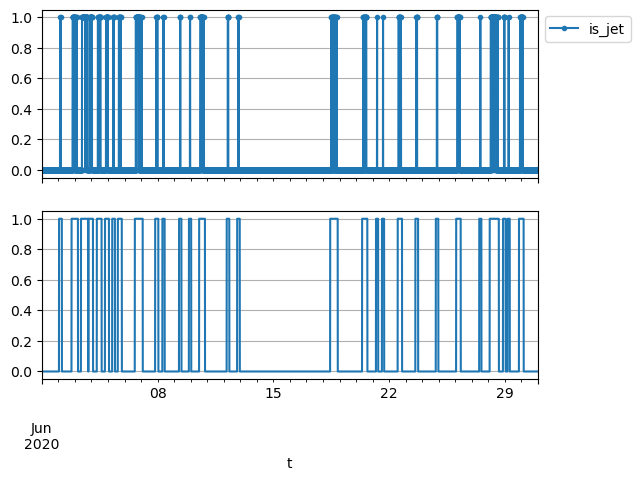

In [13]:
study_june = '2020-06'
fig,ax = plt.subplots(nrows=2,sharex=True)
isjet.loc[study_june].astype('int').plot(marker='.',ax=ax[0])
isjet_1h.loc[study_june].plot(ax=ax[1])
for axi in ax:
    axi.grid()
    lgd = axi.get_legend()
    if lgd is not None:
        lgd.remove()
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1))

In [14]:
jet_interval_start = list(jet_times[isjet_1h.diff() == 1])
jet_interval_end = list(jet_times[isjet_1h.diff() == -1])
if isjet_1h.iloc[0] == 1:
    jet_interval_start = [jet_times[0]] + jet_interval_start
if isjet_1h.iloc[-1] == 1:
    jet_interval_end = jet_interval_end + [jet_times[-1]]

assert len(jet_interval_start) == len(jet_interval_end)
assert np.all(np.array(jet_interval_end) - np.array(jet_interval_start) > pd.Timedelta('1h'))

all_jet_periods = [pd.Interval(left,right) for left,right in zip(jet_interval_start,jet_interval_end)]
intidx = pd.IntervalIndex(all_jet_periods,closed='left')

jets = pd.DataFrame(isjet_1h)
jets['event'] = None
jets['duration'] = np.nan
deltaT = jet_times[1] - jet_times[0]
for idx in intidx:
    selected = (jet_times >= idx.left) & (jet_times < idx.right)
    jets.loc[selected,'event'] = idx
    jets.loc[selected,'duration'] = len(isjet_1h.loc[selected])*deltaT

In [15]:
jet_periods = jets[['duration']].groupby(jets['event']).max()
jet_duration = jet_periods['duration'].apply(lambda td: td.total_seconds()) / 3600.

In [16]:
jet_duration.min(), jet_duration.max()

(2.8333333333333335, 20.166666666666668)

In [17]:
Nlong = np.count_nonzero(jet_duration > 11)
jet_duration.loc[jet_duration>11]

event
[2020-04-05 15:50:00, 2020-04-06 06:50:00)    15.000000
[2020-05-14 01:30:00, 2020-05-14 15:30:00)    14.000000
[2020-05-15 13:30:00, 2020-05-16 00:50:00)    11.333333
[2020-05-21 20:10:00, 2020-05-22 11:40:00)    15.500000
[2020-06-06 15:00:00, 2020-06-07 02:30:00)    11.500000
[2020-06-28 02:00:00, 2020-06-28 15:20:00)    13.333333
[2021-04-06 20:00:00, 2021-04-07 08:40:00)    12.666667
[2021-04-14 13:00:00, 2021-04-15 02:30:00)    13.500000
[2021-04-28 09:00:00, 2021-04-28 22:30:00)    13.500000
[2021-04-29 04:00:00, 2021-04-30 00:10:00)    20.166667
[2021-05-18 16:10:00, 2021-05-19 03:50:00)    11.666667
[2021-05-22 07:10:00, 2021-05-22 19:40:00)    12.500000
[2021-05-31 20:50:00, 2021-06-01 12:50:00)    16.000000
[2021-06-05 10:00:00, 2021-06-06 02:50:00)    16.833333
[2021-06-06 10:50:00, 2021-06-07 01:20:00)    14.500000
[2021-06-08 21:10:00, 2021-06-09 08:20:00)    11.166667
[2021-06-09 12:40:00, 2021-06-10 03:20:00)    14.666667
[2021-06-19 15:50:00, 2021-06-20 05:30:00)

Text(0.5, 0, 'Duration [h]')

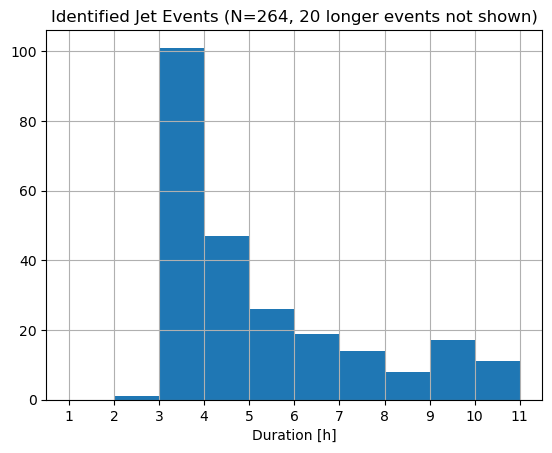

In [18]:
fig,ax = plt.subplots()
counts,edges,bars = ax.hist(jet_duration,bins=np.arange(1,12))
ax.set_xticks(edges)
ax.grid()
ax.set_title(f'Identified Jet Events (N={len(jet_duration)}, {Nlong} longer events not shown)')
ax.set_xlabel('Duration [h]')

## load fronts

In [19]:
fronts = pd.read_csv('other_data/sfc_analysis_fronts_tropicalstorms.csv',parse_dates=['datetime'])
fronts = fronts.set_index('datetime')
fronts = fronts.drop(columns=['tropical_storm'])
fronts = fronts.astype(int)
len(fronts)

6089

In [20]:
# Spring 2020
#fronts = fronts.loc[slice('2020-04-01','2020-07-01')]

# Spring 2021
#fronts = fronts.loc[slice('2021-04-01','2021-07-01')]

# non spring
#fronts = fronts.loc[slice('2020-07-01','2021-04-01')]


In [21]:
sfc_analysis_times = fronts.index
deltaT = sfc_analysis_times[1] - sfc_analysis_times[0]

In [22]:
np.count_nonzero(fronts.any(axis=1))

1854

In [23]:
expanded_fronts = fronts.rolling(front_window,center=True).max()
any_weather = expanded_fronts.any(axis=1).astype(int) # aggregate overlapping events

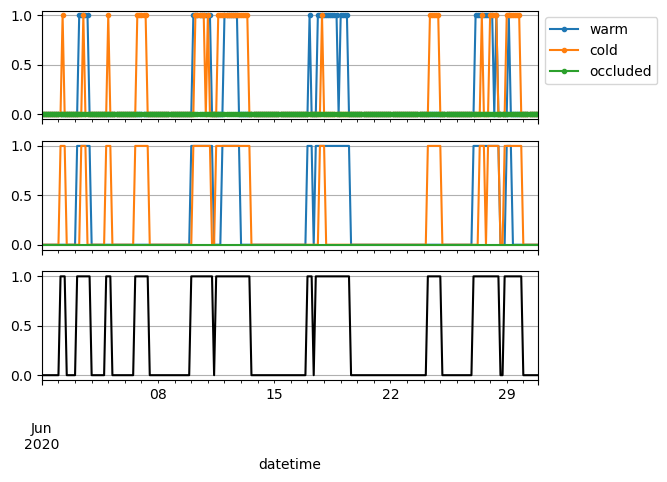

In [24]:
fig,ax = plt.subplots(nrows=3,sharex=True)
fronts.loc[study_june].plot(marker='.',ax=ax[0])
expanded_fronts.loc[study_june].plot(ax=ax[1])
any_weather.loc[study_june].plot(ax=ax[2],color='k')
for axi in ax:
    axi.grid()
    lgd = axi.get_legend()
    if lgd is not None:
        lgd.remove()
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1))

In [25]:
weather_interval_start = list(sfc_analysis_times[any_weather.diff() == 1])
weather_interval_end = list(sfc_analysis_times[any_weather.diff() == -1])
if any_weather.iloc[0] == 1:
    weather_interval_start = [sfc_analysis_times[0]] + weather_interval_start
if any_weather.iloc[-1] == 1:
    weather_interval_end = weather_interval_end + [sfc_analysis_times[-1]]

assert len(weather_interval_start) == len(weather_interval_end)
assert np.all(np.array(weather_interval_end) - np.array(weather_interval_start) > pd.Timedelta('1h'))

all_weather_periods = [pd.Interval(left,right) for left,right in zip(weather_interval_start,weather_interval_end)]
intidx = pd.IntervalIndex(all_weather_periods,closed='left')

expanded_fronts['event'] = None
expanded_fronts['duration'] = np.nan
for idx in intidx:
    selected = (sfc_analysis_times >= idx.left) & (sfc_analysis_times < idx.right)
    expanded_fronts.loc[selected,'event'] = idx
    expanded_fronts.loc[selected,'duration'] = len(expanded_fronts.loc[selected])*deltaT

In [26]:
front_periods = expanded_fronts.groupby(expanded_fronts['event']).max()
front_duration = front_periods['duration'].apply(lambda td: td.total_seconds()) / 3600.
front_periods

,warm,cold,occluded,duration
event,,,,
"[2019-09-01, 2019-09-01 06:00:00)",0.0,1.0,0.0,0 days 06:00:00
"[2019-09-02 09:00:00, 2019-09-03 18:00:00)",1.0,1.0,0.0,1 days 09:00:00
"[2019-09-04 18:00:00, 2019-09-07 12:00:00)",1.0,1.0,0.0,2 days 18:00:00
"[2019-09-08 18:00:00, 2019-09-09 03:00:00)",1.0,0.0,0.0,0 days 09:00:00
"[2019-09-12 06:00:00, 2019-09-13 06:00:00)",1.0,1.0,0.0,1 days 00:00:00
...,...,...,...,...
"[2021-09-18 21:00:00, 2021-09-19 18:00:00)",1.0,1.0,0.0,0 days 21:00:00
"[2021-09-23 12:00:00, 2021-09-25 06:00:00)",0.0,1.0,0.0,1 days 18:00:00
"[2021-09-25 09:00:00, 2021-09-26 15:00:00)",1.0,1.0,0.0,1 days 06:00:00


Text(0.5, 0, 'Duration [h]')

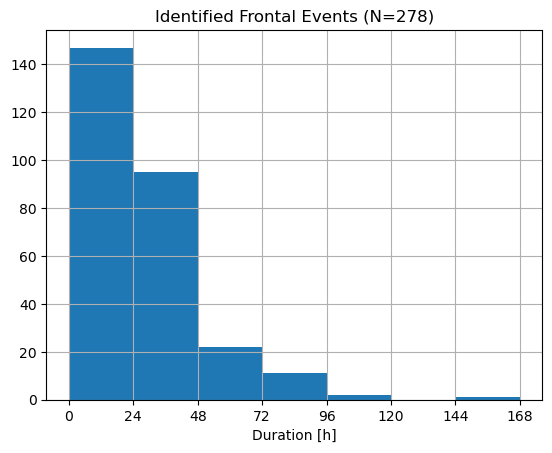

In [27]:
fig,ax = plt.subplots()
counts,edges,bars = ax.hist(front_duration,bins=np.arange(0,169,24))
ax.set_xticks(edges)
ax.grid()
ax.set_title(f'Identified Frontal Events (N={len(front_duration)})')
ax.set_xlabel('Duration [h]')

## check correspondence

In [28]:
def check_overlap(row):
    jet = row.name
    for front,details in front_periods.iterrows():
        # details is pd.Series with front type/duration
        if jet.overlaps(front):
            return True
    return False

In [29]:
jet_periods['near_front'] = jet_periods.apply(check_overlap,axis=1)

Text(0.5, 1.0, 'ASSOCIATED WITH FRONT (window=7h)')

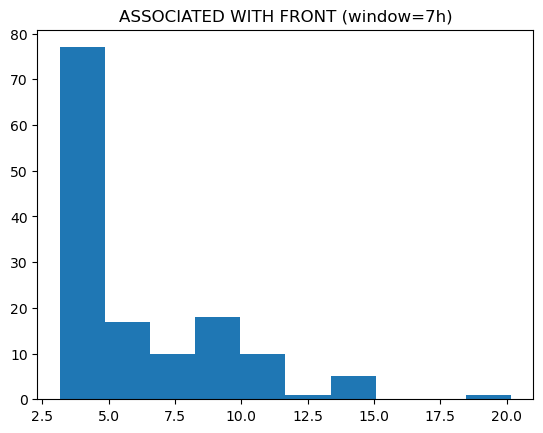

In [30]:
jet_duration_with_front = jet_periods.loc[jet_periods['near_front'],'duration'].apply(lambda td: td.total_seconds()) / 3600.
plt.hist(jet_duration_with_front)
plt.title(f'ASSOCIATED WITH FRONT (window={front_window})')

In [31]:
jet_periods

,duration,near_front
event,,
"[2019-09-06 01:00:00, 2019-09-06 05:30:00)",0 days 04:30:00,True
"[2019-09-07 21:30:00, 2019-09-08 01:10:00)",0 days 03:40:00,False
"[2019-09-12 08:00:00, 2019-09-12 17:30:00)",0 days 09:30:00,True
"[2019-09-22 09:30:00, 2019-09-22 15:30:00)",0 days 06:00:00,False
"[2019-09-29 08:40:00, 2019-09-29 11:50:00)",0 days 03:10:00,True
...,...,...
"[2022-03-21 17:40:00, 2022-03-21 22:30:00)",0 days 04:50:00,False
"[2022-03-21 23:10:00, 2022-03-22 05:50:00)",0 days 06:40:00,False
"[2022-03-22 22:30:00, 2022-03-23 02:00:00)",0 days 03:30:00,False


In [32]:
front_periods

,warm,cold,occluded,duration
event,,,,
"[2019-09-01, 2019-09-01 06:00:00)",0.0,1.0,0.0,0 days 06:00:00
"[2019-09-02 09:00:00, 2019-09-03 18:00:00)",1.0,1.0,0.0,1 days 09:00:00
"[2019-09-04 18:00:00, 2019-09-07 12:00:00)",1.0,1.0,0.0,2 days 18:00:00
"[2019-09-08 18:00:00, 2019-09-09 03:00:00)",1.0,0.0,0.0,0 days 09:00:00
"[2019-09-12 06:00:00, 2019-09-13 06:00:00)",1.0,1.0,0.0,1 days 00:00:00
...,...,...,...,...
"[2021-09-18 21:00:00, 2021-09-19 18:00:00)",1.0,1.0,0.0,0 days 21:00:00
"[2021-09-23 12:00:00, 2021-09-25 06:00:00)",0.0,1.0,0.0,1 days 18:00:00
"[2021-09-25 09:00:00, 2021-09-26 15:00:00)",1.0,1.0,0.0,1 days 06:00:00


Text(0.5, 1.0, 'NO ASSOCIATED FRONTAL ACTIVITY')

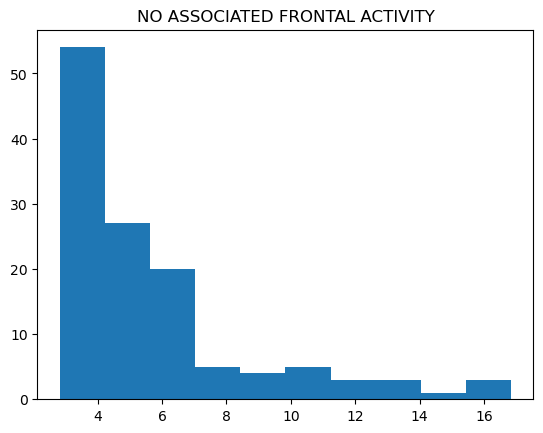

In [33]:
jet_duration_no_front = jet_periods.loc[~jet_periods['near_front'],'duration'].apply(lambda td: td.total_seconds()) / 3600.
plt.hist(jet_duration_no_front)
plt.title('NO ASSOCIATED FRONTAL ACTIVITY')

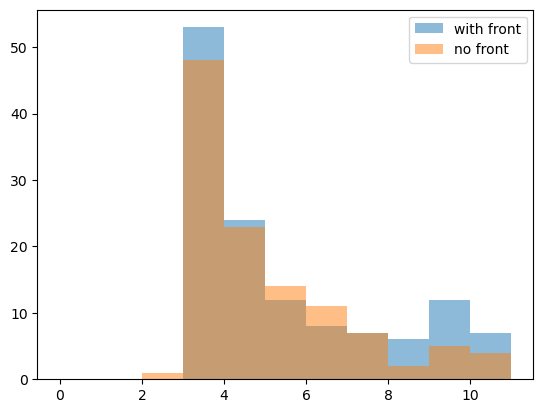

In [34]:
# does frontal activity affect jet duration?
bins = np.arange(0,12,1)
plt.hist(jet_duration_with_front,bins=bins,alpha=0.5,label='with front')
plt.hist(jet_duration_no_front,bins=bins,alpha=0.5,label='no front')
plt.legend()

In [35]:
# how often do fronts occur
front_duration.sum()*3600 / (fronts.index[-1]-fronts.index[0]).total_seconds()

# ±3h: 0.41819973718791065
# ±6h: 0.503777923784494

# spring 2020: 0.4122448979591837
# spring 2021: 0.35918367346938773
# non spring: 0.4056389267849022

0.41277923784494086

In [36]:
# how often do jets occur
jet_duration.sum()*3600 / ((jet_ids.t[-1]-jet_ids.t[0]).values/np.timedelta64(1,'s'))

# ±0.5h: 0.04992257488386233
# ±1.5h: 0.08074062111093167
# ±3.0h: 0.1180376770565156

# spring 2020: 0.1654714274930173
# spring 2021: 0.25198158073526084
# non spring: 0.03048056769110331

0.06834201427532682

In [37]:
# how often do the jets coincide with frontal activity?
jet_duration_with_front.sum() / jet_duration.sum()

# ±3h/±0.5h front/jet: 0.5394862036156042
# ±6h/±0.5h front/jet: 0.5965746907706946
# ±3h/±1.5h front/jet: 0.584539357571479
# ±3h/±3.0h front/jet: 0.6185915492957746

# spring 2020: 0.573905109489051
# spring 2021: 0.4601557819053325
# non spring: 0.8558409279204641

0.5393551188796005